# Meta
https://www.python-graph-gallery.com/324-map-a-color-to-network-nodes \

https://networkx.org/documentation/stable/index.html


# Audible Data Analysis

#### Data Scraped on 5/10/21

### Introduction
This notebook documents the data analysis of the title and category information scraped from Audible.com and Amazon.com. Generally we will focus on book length, price, ratings, and number of listens. 


### Requirements
Please run the web scraping programs below before analsis. Static images will be included in the presentation accompanying this notebook. **Confirm requirements.txt is met**:
- books_scrapy_audible -> category_spider
- books_scrapy_audible -> titles_spider

Running these programs should result in the following csv files
- books_scrapy_audible -> category_hierarchy_n_urls.csv
- books_scrapy_audible -> title_information.csv

In [72]:
import numpy as np
import seaborn as sns
import pandas as pd
from statistics import mode
import networkx as nx
import matplotlib.pyplot as plt
import missingno

### Data Import
Due to the nature of the scraping program, which you can read about in the README.md, most titles have been scraped multiple times. Luckily all urls lead to the same product and are unique so they can help us easily filter for unique titles, and categories can be condensed into a list which will act like a list of tags. 

In [73]:
cat_data   = pd.read_csv("books_scrapy_audible/category_hierarchy_n_urls.csv")
title_data = pd.read_csv("books_scrapy_audible/title_information.csv")

In [3]:
cat_data.head()

,category_name,category_numb_title,leaf_flag,parent_category,parent_url,self_url,title_list_url
0,Travel & Tourism,8631,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Travel-Tourism-Aud...,https://www.audible.com/search?node=1858109501...
1,Teen,18661,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Teen-Audiobooks/18...,https://www.audible.com/search?node=1858071501...
2,Sports & Outdoors,22415,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Sports-Outdoors-Au...,https://www.audible.com/search?node=1858064801...
3,Science Fiction & Fantasy,61202,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Fiction-Fa...,https://www.audible.com/search?node=1858060601...
4,Science & Engineering,17495,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Engineerin...,https://www.audible.com/search?node=1858054001...


In [4]:
title_data.head()

,author,count_rating,language,length,narrator,pod_flag,price,release_date,star_rating,subtitle,title,title_category,title_url
0,Yuval Noah Harari,43059.0,English,917,Derek Perkins,False,34.22,08-15-17,4.5,A Brief History of Humankind,Sapiens,Biological Sciences,https://www.audible.com/pd/Sapiens-Audiobook/B...
1,Walter Isaacson,1622.0,English,964,"Kathe Mazur,Walter Isaacson",False,28.34,03-09-21,4.5,"Jennifer Doudna, Gene Editing, and the Future ...",The Code Breaker,Biological Sciences,https://www.audible.com/pd/The-Code-Breaker-Au...
2,James Nestor,4300.0,English,438,James Nestor,False,24.50,05-26-20,5.0,The New Science of a Lost Art,Breath,Biological Sciences,https://www.audible.com/pd/Breath-Audiobook/05...
3,Robin Wall Kimmerer,4346.0,English,1004,Robin Wall Kimmerer,False,34.99,12-27-15,5.0,"Indigenous Wisdom, Scientific Knowledge and th...",Braiding Sweetgrass,Biological Sciences,https://www.audible.com/pd/Braiding-Sweetgrass...
4,Suzanne Simard,5.0,English,733,Suzanne Simard,False,31.50,05-04-21,5.0,Discovering the Wisdom of the Forest,Finding the Mother Tree,Biological Sciences,https://www.audible.com/pd/Finding-the-Mother-...


### Category Structure
Audible has a variety of categories allowing the user to filter their search as desired. Interestingly the category system seems to function more like tags, with content belonging to multiple unconnected categories. Additionally, since only 1200 results are displayed in the search pane, categories containing more than 1200 titles are generally broken down into sub-categories. 

There are 1171 listed categories, 121 redirect to another page, so 1050 were scraped. 

So instead of __ we get directed to __:
- Childrens / Action-Adventure -> Literature-Fiction / Action-Adventure
- Fairy-Tales-Folk-Tales-Myths / Adaptations -> Fantasy-Magic / Fairy-Tale-Adaptations
- Biographies / Historical -> History / Historical-Biographies

#### EDA

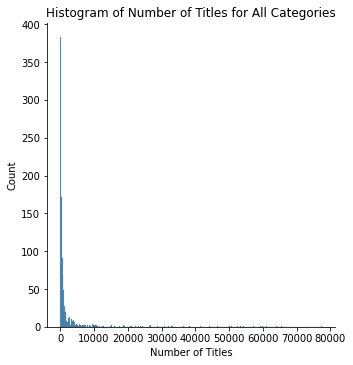

In [40]:
data = cat_data['category_numb_title']
plot = sns.displot(data)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles for All Categories")

#plt.show()
plt.savefig("./graphics/hist_cats.png", bbox_inches = 'tight')

In [34]:
big_bois = cat_data[cat_data['parent_category']== 'Audible'].filter(items = ['category_name','category_numb_title'])
big_bois.columns = ['Top Level Category Name','Number of Titles']
big_bois.set_index('Top Level Category Name')

,Number of Titles
Top Level Category Name,
Travel & Tourism,8631
Teen,18661
Sports & Outdoors,22415
Science Fiction & Fantasy,61202
Science & Engineering,17495
Romance,63904
Religion & Spirituality,55302
"Relationships, Parenting & Personal Development",58980
Politics & Social Sciences,59844


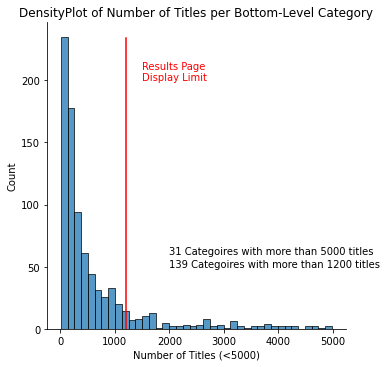

In [17]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']
plot = sns.displot(data2)

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=200, s= "Results Page \nDisplay Limit", color = 'r')

plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


#plt.show()
plt.savefig("./graphics/hist_leafs.png", bbox_inches = 'tight')

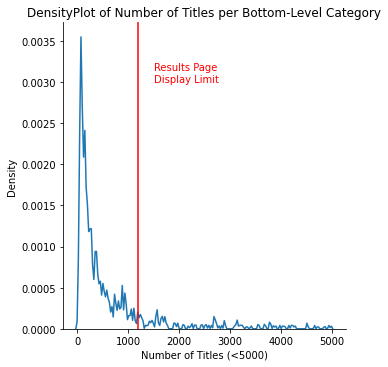

In [29]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']

plot = sns.displot(data2, kind = 'kde', bw_adjust = 0.05)

plt.axvline(1200, 0, 1, color = 'r')
plt.text(x=1500, y=0.003, s= "Results Page \nDisplay Limit", color = 'r')

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')

#plt.show()
plt.savefig("./graphics/density_leafs.png", bbox_inches = 'tight')

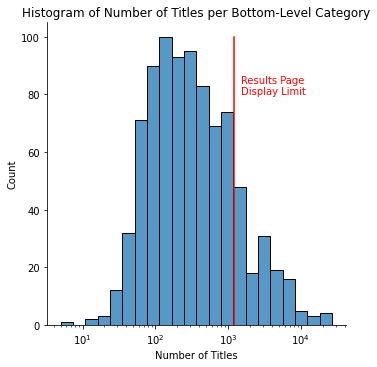

In [204]:
data2 = cat_data[cat_data['leaf_flag']==True]['category_numb_title']
plot = sns.displot(data2,log_scale = True)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=80, s= "Results Page \nDisplay Limit", color = 'r')

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


plt.show()
#plt.savefig("./graphics/hist_log_leafs.png", bbox_inches = 'tight')

In [24]:
large_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >5000)]['category_numb_title']
print("There are {} leaf categories with more than 5000 titles.".format(len(large_leafs)))

display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
print("There are {} leaf categories with more than 1200 titles, the display limit.".format(len(display_limit_leafs)))

There are 31 leaf categories with more than 5000 titles.
There are 139 leaf categories with more than 1200 titles, the display limit.


In [5]:
cat_data[(cat_data['leaf_flag']==True)].shape

(869, 7)

In [41]:
display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
string = "{} is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories."
print(string.format(sum(display_limit_leafs)))

583153 is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories.


This offers the oppurtunity to expand these leaf-categories into sub-categories which could provide the user more choice. Significantly the top level category of **Erotica** only has two sub-categories **Literature & Fiction** and **Sexual Instruction** which is suprising considering Audible has a feature [specifically targeted](https://qz.com/1116293/audible-is-launching-a-feature-that-lets-you-jump-right-to-the-most-erotic-part-of-an-audiobook/) at this category of audiobooks. My best alternative hypothesis is most **Erotica/Literature & Fiction** titles are also represented in the **Romance** section which is broken down into many sub-categories.  

Personal Success might offer an easy split "Managing your vanity" and "How does my hair look?"

In [54]:
# Top and bottom categories
data2      = cat_data[cat_data['leaf_flag']==True]
top_       = data2.sort_values('category_numb_title',ascending = False).head(5)
bottom_    = data2.sort_values('category_numb_title',ascending = False).tail(5)
top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title'])
top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles']

#Get URL
#top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title', 'self_url'])
#top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles', 'Category URL']
#print(top_bottom.to_string())

top_bottom

,Parent Category,Category Name,Number of Titles
174,Personal Development,Personal Success,26798
823,Thriller & Suspense,Suspense,26385
597,Erotica,Literature & Fiction,23118
251,Romance,Contemporary,20868
925,Management & Leadership,Leadership,16045
857,Biographies,Adventurers & Explorers,18
396,"Health, Lifestyle & Relationships",Sexuality & Sexual Health,17
426,Historical Fiction,Action & Adventure,16
401,Science Fiction,Anthologies & Short Stories,13
587,Language Learning,Latin,5


426 : Teen / Lit & Fic / Historical Fiction / A & A

401 : Teen / Scifi & Fantasy / SciFi / Anthology...



#### Network Visualization

In [96]:
# adding a false entry to make assignments easier. 
cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

#Creating new column for better node visualization
cat_data['log_numb_title'] = np.log(cat_data['category_numb_title'])
cat_data['scaled_numb_title'] = np.interp(cat_data.category_numb_title,
                                         (cat_data.category_numb_title.min(),
                                         cat_data.category_numb_title.max()),
                                         (1,300))
cat_data['scaled_log_numb_title'] = np.interp(cat_data.log_numb_title,
                                         (cat_data.log_numb_title.min(),
                                         cat_data.log_numb_title.max()),
                                         (1,300))

ValueError: Received invalid argument(s): layout

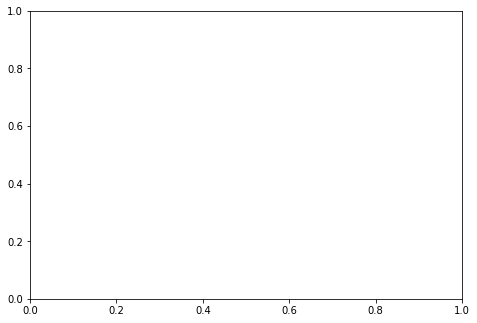

In [3]:
graph = nx.from_pandas_edgelist(cat_data, 'parent_url','self_url', create_using=nx.DiGraph())

node_info = cat_data.set_index('self_url').reindex(graph.nodes())
#node_dic  = node_info.filter(['category_name']).T.to_dict('dict')

nx.draw(graph, 
        with_labels = False,
        labels      = node_info['category_name'],
        arrows      = True,
        #node_color  = node_info['category_numb_title'],
        node_size   = node_info['category_numb_title'], # pretty good
        #node_size   = node_info['log_numb_title'], # very small points, 
        #node_size   = node_info['scaled_numb_title'], # very small points
        #node_size   = node_info['scaled_log_numb_title'], #visable points, too small
        #pos         = nx.fruchterman_reingold_layout(graph) #doesnt seem to work
        layout       = nx.kamada_kawai_layout(graph) #doesnt quite work
       )
#plt.rcParams['figure.figsize'] = (50,50)
plt.title("Audible Categories")
#plt.show()
#plt.savefig("category_network.png")




https://stackoverflow.com/questions/40092390/network-graph-is-not-visually-optimized-in-networkx

In [15]:
del graphviz
del pygraphviz

NameError: name 'pygraphviz' is not defined

In [4]:
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [5]:
import pygraphviz

ModuleNotFoundError: No module named 'pygraphviz'

In [6]:
#import graphviz
#import pygraphviz
#from networkx.drawing.nx_agraph import to_agraph

ImportError: cannot import name '_graphviz' from partially initialized module 'pygraphviz' (most likely due to a circular import) (c:\users\james\dropbox\nydsa\projects\web scraping\finding_the_tree_in_the_forest\local-env\lib\site-packages\pygraphviz\__init__.py)

In [5]:
import graphviz
#import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

edges = list(zip(cat_data.parent_url, cat_data.self_url))


labels = dict(zip(cat_data.self_url,cat_data.category_name))


G = nx.DiGraph() # Create an empty Graph

for k,v in labels.items():
    G.add_node(k,label=v)
G.add_edges_from(edges)

A = to_agraph(G)

A.draw('hier_categories.png', prog='dot') # Hierarchical
A.draw('circular_categories.png', prog='neato') #circular

ImportError: requires pygraphviz http://pygraphviz.github.io/

In [ ]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

graph = nx.DiGraph()
graph.add_nodes_from()
graph.add_edges_from()


# SOME EDA ABOUT THE categories

# Title information

- most prolific author, narrator
- author in most categories?
- narrator by category
- length vs price vs star/count
- space for audio dramas?
- category timeseries
- length over time?
- price vs rating
- price vs length?
- common price vs length
- deep dive into the dubbing / model out the costs.
- whats up with 2013-2014


#### Cleaning Duplicates and Filtering Podcasts
Since Audible treats categories more like tags, most titles belonging to multiple, there is a significant number of duplicated titles and information. 


Podcasts are also present in our data, which I didn't know Audible offered, but since they are not the focus of the scraping they are discarded. 

Number of titles scraped:  622065
Number of unique titles (books+pods):  286200
Unique Podcasts:  6959
Unique Books:  279241


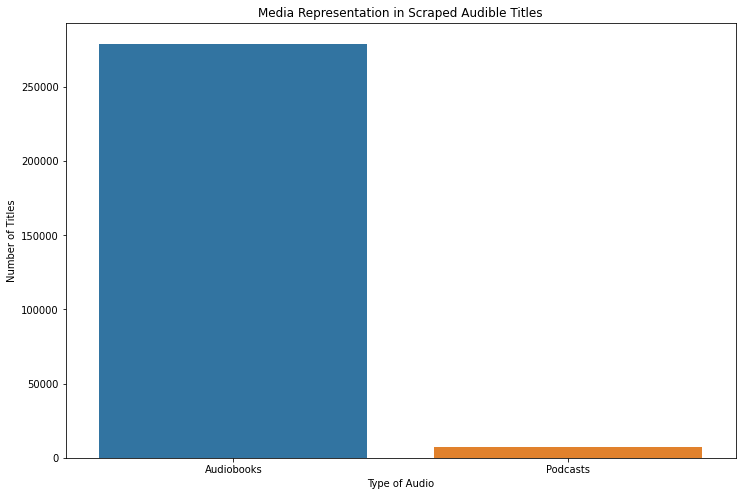

In [74]:
print("Number of titles scraped: ", len(title_data.title_url) )
print("Number of unique titles (books+pods): ", len(np.unique(title_data.title_url)))
print("Unique Podcasts: ",len(np.unique(title_data.title_url[title_data.pod_flag == True])))
print("Unique Books: ",len(np.unique(title_data.title_url[title_data.pod_flag == False])))

data = np.where(title_data.drop_duplicates(subset = ['title_url'])['pod_flag'] == True, "Podcasts", "Audiobooks" )
sns.countplot(x=data).set(xlabel="Type of Audio", ylabel = "Number of Titles")

plt.title("Media Representation in Scraped Audible Titles")

plt.savefig("./graphics/media_types.png", bbox_inches = 'tight')

In [75]:
# Remove podcasts from dataframe
title_data = title_data.loc[title_data.pod_flag == False]

Due to titles appearing in multiple categories, other fields were effected which were cleaned in the following manner.
- **title_category**: collapsed into a list.
- **count_rating**: max value retained.  
- **star_rating**: max value retained.
- **release_date**: max value retained. I believe this is due to reuploading into a new category.
- **length**: max value retained. I believe this is due to reuploading into a new category.
- **category_number**: New Column, number of categories a title was scraped in.

In [109]:
group_bys = list(title_data.columns)
group_bys.remove("title_category")
group_bys.remove("star_rating")
group_bys.remove("count_rating")
group_bys.remove("release_date")
group_bys.remove("length")

titles = title_data.groupby(group_bys, dropna = False).agg({
                                              'release_date'  :'max',
                                              'length'        :'max',
                                              'star_rating'   :'max', 
                                              'count_rating'  :'max',
                                              'title_category': lambda x: list(x)}
                                            ).reset_index()




"This leaves {} books remaining, compared to the +200,000 reported publically by Audible".format(len(np.unique(titles.title_url)))

'This leaves 279241 books remaining, compared to the +200,000 reported publically by Audible'

<AxesSubplot:>

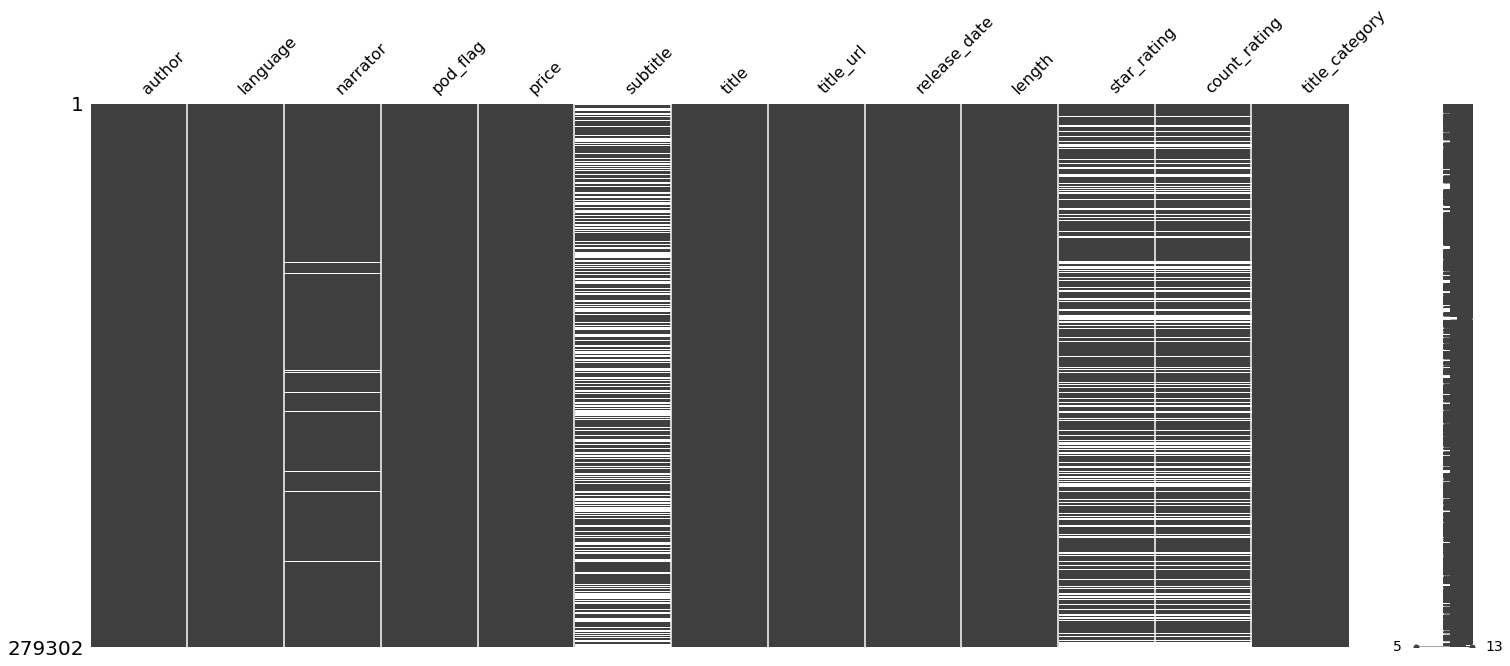

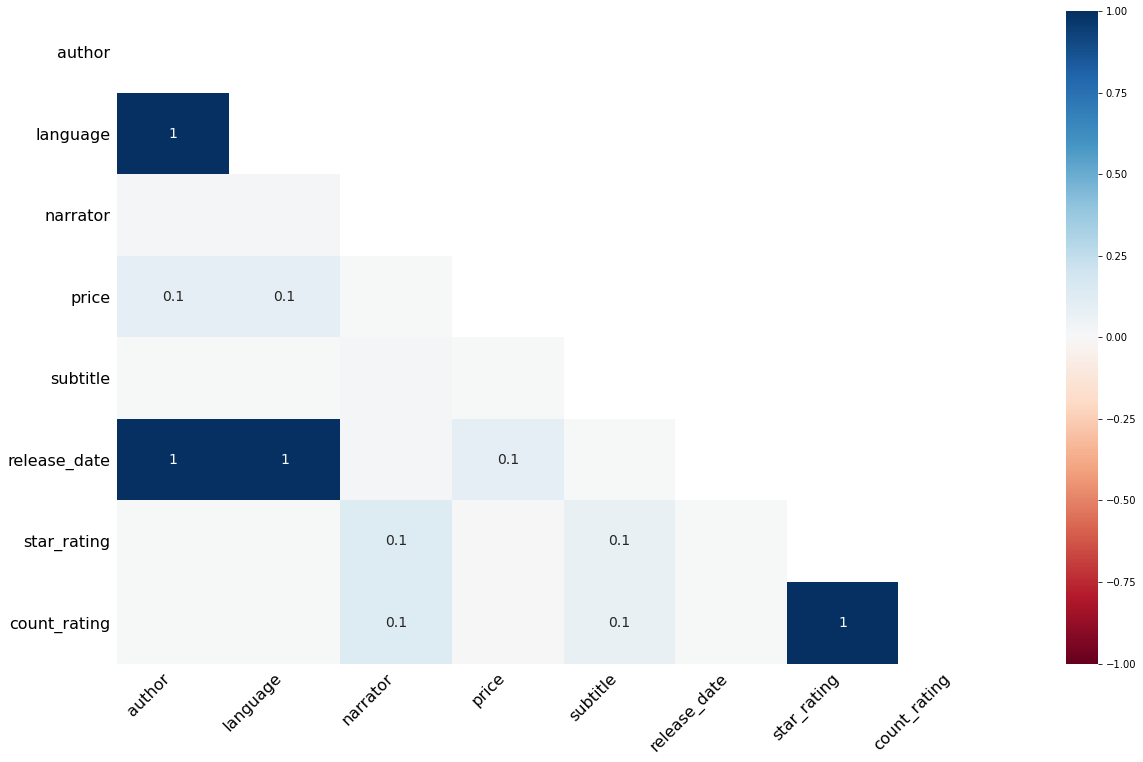

In [33]:
import missingno as msno

msno.matrix(titles)
msno.heatmap(titles)

#### Adding new columns for later use.
Most code chunks will also derive the column in case chunks are run out of order. 

In [77]:
titles['subtitle']      = titles['subtitle'].replace(np.nan, "")
titles['count_rating']  = titles['count_rating'].fillna(0)

titles['category_number'] = titles['title_category'].str.len()

titles['author']        = [x.split(',') for x in titles.author.replace(np.nan,"")]
titles['narrator']      = [x.split(',') for x in titles.narrator.replace(np.nan,"")]

titles['pub_datetime']  = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

titles['language']      = titles['language'].str.replace("_"," ").str.title()


#### Some fun facts

In [7]:
# To help make printing easier
def full_title(row):
    row = row.fillna("")
    return ("{0}: {1} written by {2}, narrated by {3}".format(row.title.values[0], row.subtitle.values[0], row.author.values[0], row.narrator.values[0]))

In [57]:
#titles.sort_values('count_rating', ascending=False).head(3).set_index("count_rating").apply(full_title,axis=1).reset_index().columns("Number of Ratings","Title Info")

top_counts = titles.sort_values('count_rating', ascending=False).head(3)
top_rating = titles[titles.star_rating == 5].sort_values('count_rating', ascending=False).head(3)
expensive  = titles.sort_values('price', ascending = False).head(3)
cheap      = titles.sort_values('price', ascending = True).head(3)



# Number of Categories

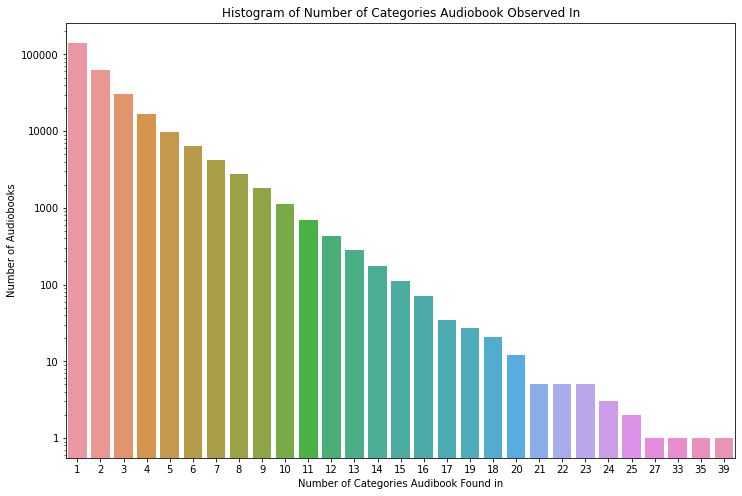

In [78]:
plot = sns.countplot(x='category_number', 
                     data = titles, 
                     order = titles['category_number'].value_counts().index)

plot.set_xlabel("Number of Categories Audibook Found in")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Number of Categories Audiobook Observed In")

plt.savefig("./graphics/cat_numb_hist.png", bbox_inches = 'tight')

plot.set_yscale('log')
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)
plt.savefig("./graphics/cat_numb_log_hist.png", bbox_inches = 'tight')

In [139]:
titles.sort_values('category_number', ascending = False).head(4)

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number
260381,Timothy Snyder,English,Ralph Cosham,False,29.95,Europe Between Hitler and Stalin,Bloodlands,https://www.audible.com/pd/Bloodlands-Audioboo...,10-12-18,1096,5.0,390.0,"[United States, Austria & Hungary, Russia, Gre...",39
241047,Sherry Turkle,English,Laural Merlington,False,31.49,Why We Expect More from Technology and Less fr...,Alone Together,https://www.audible.com/pd/Alone-Together-Audi...,05-10-11,885,3.5,210.0,"[Philosophy, Workplace Culture, Workplace & Or...",35
30885,Brendan Simms,English,Leighton Pugh,False,30.79,A Global Biography,Hitler,https://www.audible.com/pd/Hitler-Audiobook/15...,10-01-19,1757,4.5,46.0,"[Japan, Austria & Hungary, Asia, Russia, Italy...",33


# Titles and Subtitles

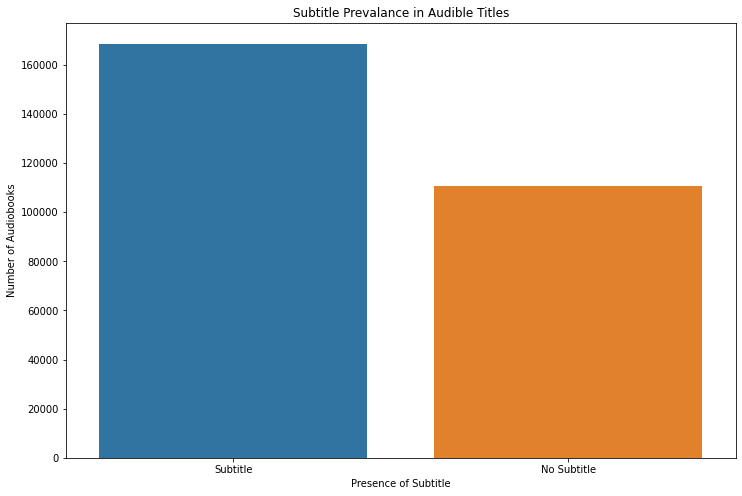

In [79]:
data = (titles['subtitle'] != "").replace({True:"Subtitle",False:"No Subtitle"})

plot = sns.countplot(x=data)

plot.set_xlabel("Presence of Subtitle") 
plot.set_ylabel("Number of Audiobooks")

plt.title("Subtitle Prevalance in Audible Titles")

plt.savefig("./graphics/sub-title_count.png", bbox_inches = 'tight')

Median Price: 4.0
Mode Price: 0    3
dtype: int64


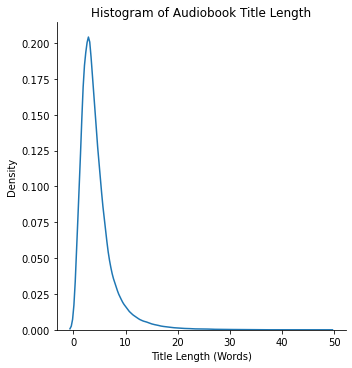

In [80]:
data_word = titles.title.str.split().str.len()

plot2= sns.displot(data_word, kind = 'kde',bw_adjust=2)

plot2.set_axis_labels("Title Length (Words)")
plt.title("Histogram of Audiobook Title Length")

print("Median Price: {}".format(data_word.median()))
print("Mode Price: {}".format(data_word.mode()))

plt.savefig("./graphics/title_word_hist.png", bbox_inches = 'tight')

In [81]:
#pd.set_option('display.max_colwidth', None)
titles['title_length'] = titles.title.str.split().str.len() 
titles.sort_values('title_length', ascending = False).head(3)#['title_url'][0:3]

#weirdly the counts are the same?
# similar release dat

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,title_length
93714,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Tailandia: Tips ese...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-17-20,60,5.0,200.0,[Asia],1,2020-01-17,3837,48
93715,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Tailandia: Tips ese...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-14-20,61,5.0,200.0,"[Adventure Travel, Asia]",2,2020-01-14,3817,46
93713,[Giselle Johnson],Spanish,[Keymer Roa],False,6.95,,Guía de Viaje económica de Alemania: Tips esen...,https://www.audible.com/pd/Guia-de-Viaje-econo...,01-14-20,62,5.0,200.0,[Europe],1,2020-01-14,3819,44


Median Price: 6.0
Mode Price: 0    5
dtype: int64


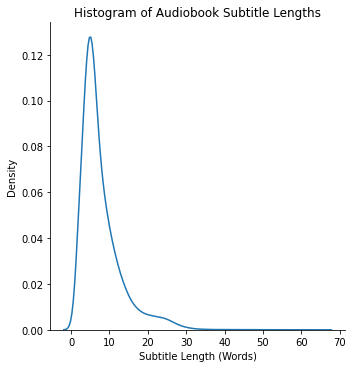

In [82]:
data_word = titles.subtitle.str.split().str.len()
data_word = data_word[data_word != 0]

plot2= sns.displot(data_word, kind = 'kde',bw_adjust=2)
plot2.set_axis_labels("Subtitle Length (Words)")
plt.title("Histogram of Audiobook Subtitle Lengths")

print("Median Price: {}".format(data_word.median()))
print("Mode Price: {}".format(data_word.mode()))

plt.savefig("./graphics/subtitle_word_hist.png", bbox_inches = 'tight')

In [83]:
#pd.set_option('display.max_colwidth', None)
titles['subtitle_length'] = titles.subtitle.str.split().str.len() 
titles.sort_values('subtitle_length', ascending = False).head(3)#['title_url'][0:3]


,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,title_length,subtitle_length
71583,[Dr. Stanley Leary],Spanish,[Gonzalo Abad Cortes],False,19.95,"La Guia Definitiva Para La Felicidad, Aumentar...",Inteligencia Emotional (Emotional Intelligence),https://www.audible.com/pd/Inteligencia-Emotio...,05-29-20,410,5.0,3.0,[Stress Management],1,2020-05-29,4519,4,65
256357,"[The Cosmovisioners, Carlos Augusto Miguel Gue...",Spanish,[Dinorah Pena-Duran],False,14.95,Guía simple e intuitiva para aprender la lectu...,Tarot Para Principiantes [Tarot for Beginners],https://www.audible.com/pd/Tarot-Para-Principi...,03-17-21,246,5.0,25.0,[Divination],1,2021-03-17,6553,6,63
239809,[Sharon McKinsey],Spanish,[Maria],False,19.95,Comprender la Teoría de los Estilos de Relació...,Trastorno de Apego [Attachment Theory],https://www.audible.com/pd/Trastorno-de-Apego-...,03-12-21,338,5.0,50.0,"[Codependency, Self-Esteem]",2,2021-03-12,6525,5,62


### Languages

In [84]:
s         = "There are {} languages represented in Audible's library."
numb_lang = len(titles.language.unique())

print(s.format(numb_lang))

There are 44 languages represented in Audible's library.


A large majority of audiobooks are narrated and avalible in English.

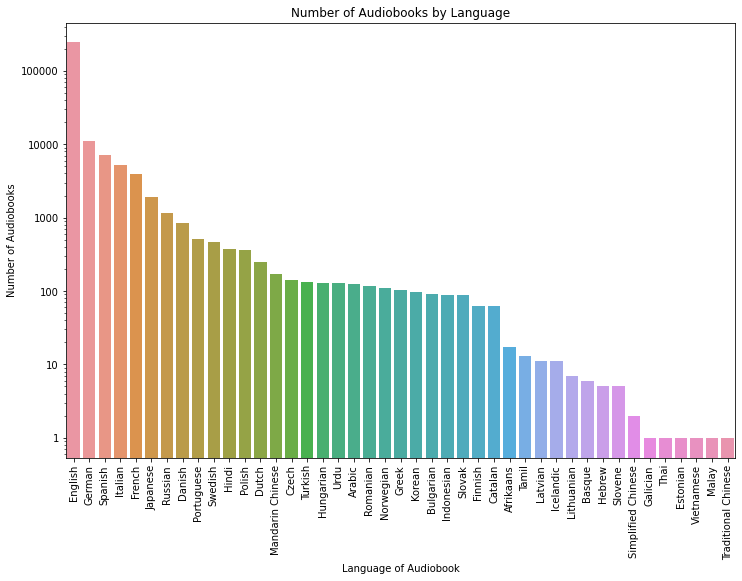

In [85]:
titles['language'] = titles['language'].str.replace("_"," ").str.title()

plot = sns.countplot(x='language', 
                     data = titles, 
                     order = titles['language'].value_counts().index)

plot.set_yscale('log')
plot.set_xlabel("Language of Audiobook")
plot.set_ylabel("Number of Audiobooks")

plt.xticks(rotation =90)
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

plt.title("Number of Audiobooks by Language")
plt.rcParams['figure.figsize'] = (8,8)

plt.savefig("./graphics/languages.png", bbox_inches = 'tight')

English language audiobooks are the largest language and show no signs of stopping. We can even see the expected releases in the coming years. 

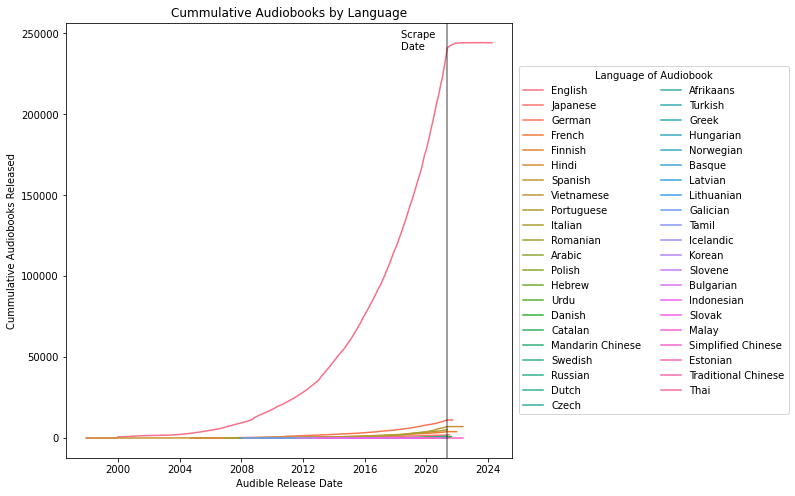

In [86]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

plt.rcParams['figure.figsize'] = (8,8)

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_lang_pub',
             hue = titles['language'].str.replace("_"," ").str.title(),
             ci  = None)

plt.title("Cummulative Audiobooks by Language")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Language of Audiobook",
            loc='center right', 
            bbox_to_anchor=(1.63, 0.5), 
            ncol=2)

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/lang_timeseries.png", bbox_inches = 'tight')

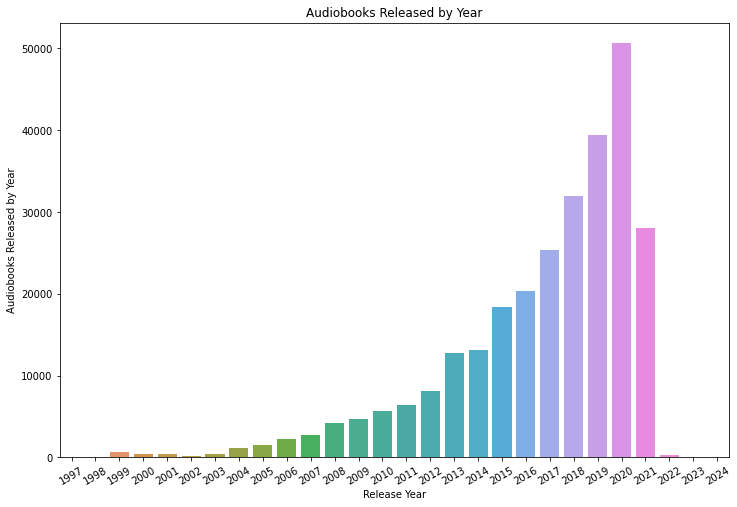

In [124]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
years = pd.DatetimeIndex(titles.pub_datetime).year

plt.rcParams['figure.figsize'] = (12,8)

plot = sns.countplot(x = years)

plot.set_xticklabels(range(1997,2025))

plt.title("Audiobooks Released by Year")
plot.set_xlabel("Release Year")
plt.xticks(rotation =30)
plot.set_ylabel("Audiobooks Released by Year")

plt.savefig("./graphics/lang_timeseries_box.png", bbox_inches = 'tight')

In [107]:
titles[pd.DatetimeIndex(titles.pub_datetime).year == 1997]

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,title_length,subtitle_length,self_narrator,cumm_self_nar
132030,[John Berendt],English,[Anthony Heald],False,19.93,,Midnight in the Garden of Good and Evil,https://www.audible.com/pd/Midnight-in-the-Gar...,12-02-97,189,4.0,82.0,"[Murder, True Crime, State & Local]",3,1997-12-02,0,8,0,False,0
162840,[Liliana Montesco],Spanish,[Graciela Lecube],False,12.24,,Pasion sin Fronteras [Boundless Passion],https://www.audible.com/pd/Pasion-sin-Frontera...,12-08-97,73,3.0,1.0,[City Life],1,1997-12-08,0,5,0,False,1


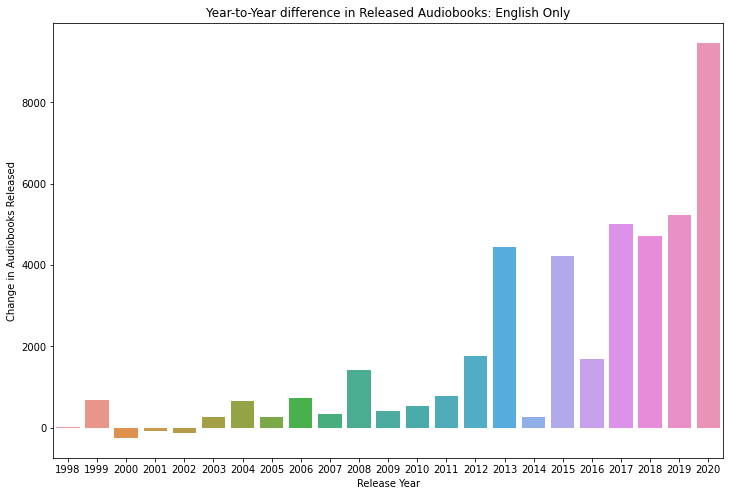

In [88]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
data = titles.loc[titles['language'] == 'English','pub_datetime']
years = pd.DatetimeIndex(data).year
years = years.value_counts().sort_index().diff().drop(labels = [1997,2021,2022,2023,2024])


plt.rcParams['figure.figsize'] = (12,8)

plot = sns.barplot(x=years.index, y =years)

plt.title("Year-to-Year difference in Released Audiobooks: English Only")
plot.set_xlabel("Release Year")
plot.set_ylabel("Change in Audiobooks Released")

plt.savefig("./graphics/eng_lang_growth.png", bbox_inches = 'tight')

In [106]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
data = titles.loc[titles['language'] == 'English','pub_datetime']
years = pd.DatetimeIndex(data).year
years = years.value_counts().sort_index()#.drop(labels = [1997,2021,2022,2023,2024])
years

1997        1
1998       15
1999      697
2000      446
2001      358
2002      221
2003      475
2004     1136
2005     1405
2006     2149
2007     2492
2008     3912
2009     4335
2010     4879
2011     5660
2012     7414
2013    11858
2014    12123
2015    16335
2016    18026
2017    23048
2018    27753
2019    32991
2020    42458
2021    23816
2022      249
2023        8
2024        2
Name: pub_datetime, dtype: int64

### Author as Narrator

In [90]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
titles['cumm_self_nar'] = titles.sort_values('pub_datetime', ascending = True).groupby('self_narrator',dropna=True).cumcount()


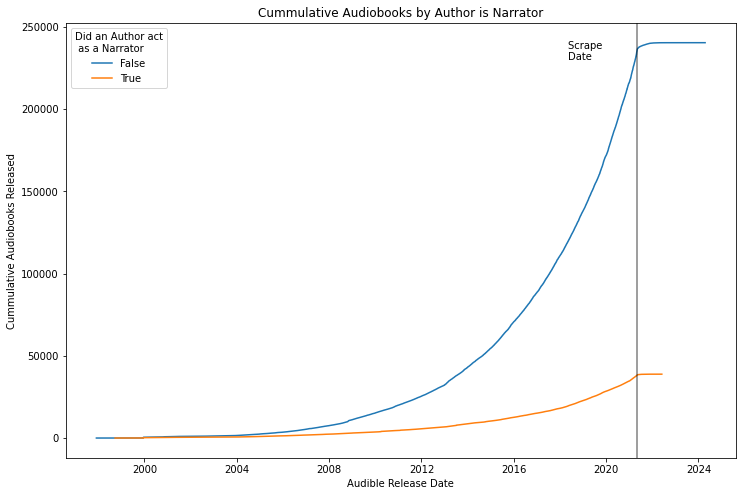

In [91]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
titles['cumm_self_nar'] = titles.sort_values('pub_datetime', ascending = True).groupby('self_narrator',dropna=True).cumcount()

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_self_nar',
             hue = 'self_narrator',
             ci  = None)

plt.title("Cummulative Audiobooks by Author is Narrator")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Did an Author act\n as a Narrator")

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),230000, "Scrape \nDate", color ='k')

plt.rcParams['figure.figsize'] = (8,8)


plt.savefig("./graphics/self_narr_timeseries.png", bbox_inches = 'tight')

### Price Distribution

There are 2539 audiobooks greater than $40.


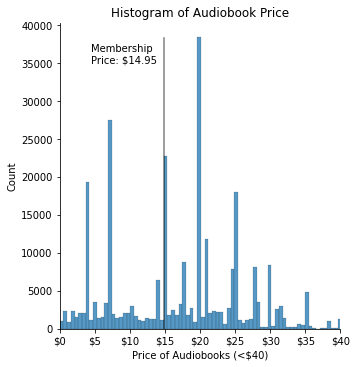

In [92]:
plot = sns.displot(titles.price, kind = 'hist')

plt.axvline(14.90, 0, 0.95, color = 'k', alpha = 0.5) # price adjusted for visual clarity
plt.text(x=4.5, y=35000, s= "Membership \nPrice: $14.95", color = 'k')

plot.set_axis_labels("Price of Audiobooks (<$40)")
plt.title("Histogram of Audiobook Price")

plt.xlim(0,40)

xticks = ["$"+str(x) for x in range(0,41,5)]
plot.set_xticklabels(xticks)

plt.savefig("./graphics/hist_price.png", bbox_inches = 'tight')

print("There are {} audiobooks greater than $40.".format(titles[titles.price>40].shape[0]))

https://kenthendricks.com/audible-pricing/

In [93]:
price_str = titles['price'].astype(str).apply(lambda x: "$"+x)
price_str = price_str.groupby(price_str).size().sort_values(ascending= False)[0:10].to_frame()
price_str.columns = ['Number of Books']

print("Median Price: {}".format(titles.price.astype(str).median()))
print("Most Common Prices for audiobooks")
price_str

Median Price: 18.16
Most Common Prices for audiobooks


,Number of Books
price,
$19.95,35103
$6.95,24551
$14.95,22088
$3.95,16837
$24.95,15953
$17.49,7144
$20.99,6818
$27.99,4211
$29.95,4060


There are 158886 Audiobooks more expensive than the $14.95 membership fee.
There are 120416 Audiobooks cheaper than the $14.95 membership fee.


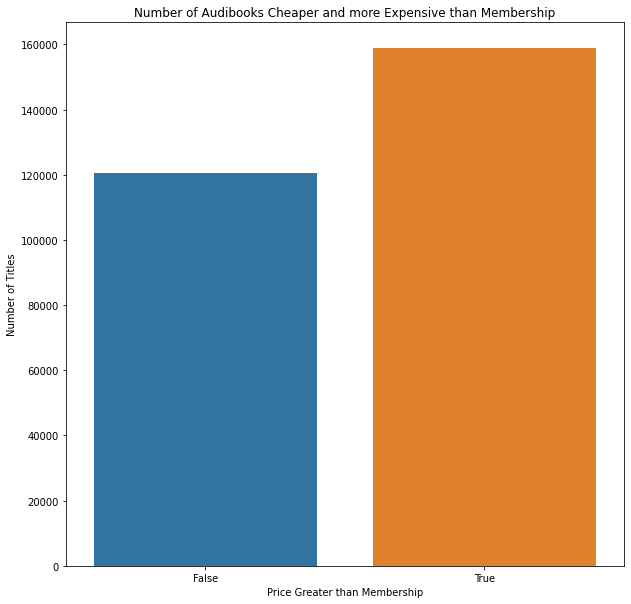

In [110]:
price_split = titles.price.groupby(titles.price>14.95).size().to_frame()

s1 = "There are {} Audiobooks more expensive than the $14.95 membership fee."
s2 = "There are {} Audiobooks cheaper than the $14.95 membership fee."

print(s1.format(price_split.loc[True]['price']))
print(s2.format(price_split.loc[False]['price']))


plot = sns.barplot(x = price_split.index, y = price_split.price)                
plot.set(xlabel="Price Greater than Membership", ylabel = "Number of Titles")

plt.title("Number of Audibooks Cheaper and more Expensive than Membership")

plt.savefig("./graphics/price_membership.png", bbox_inches = 'tight')

### Length Distribution

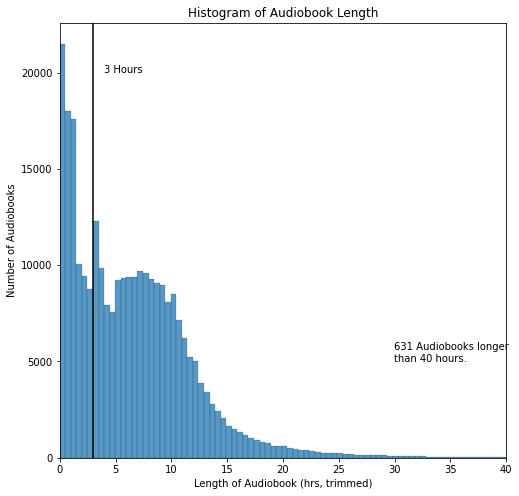

In [95]:
plot = sns.histplot(x = (titles.length/60),bins = 288)

plot.set_xlabel("Length of Audiobook (hrs, trimmed)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Length")
plt.xlim(0,40)
plt.rcParams['figure.figsize'] = (10,10)

plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
plt.text(x=4, y=20000, s= "3 Hours", color = 'k')

plt.text(x=30, y=5000, s= "{} Audiobooks longer\nthan 40 hours.".format(titles[titles.length>2400].shape[0]), color = 'k')

plt.savefig("./graphics/hist_length.png", bbox_inches = 'tight')

#top 3 longest.
#All DEAD
#https://www.audible.com/pd/All-DEAD-Audiobook/B07YF3XH93
#Natsume Soseki Masterpiece Collection
#https://www.audible.com/search?keywords=%E5%A4%8F%E7%9B%AE%E6%BC%B1%E7%9F%B3%E5%90%8D%E4%BD%9C%E9%9B%86&ref=a_search_t1_header_search
#Complete Works of Mimei Ogawa Fairy Tales
#https://www.audible.com/pd/705-Audiobook/B07JY9D1Q7?qid=1621966151&sr=1-1&ref=a_search_c3_lProduct_1_1&pf_rd_p=83218cca-c308-412f-bfcf-90198b687a2f&pf_rd_r=W7X2DH66FXW439HDZW9G

- heard >3 hours is better than <3?
- https://news.ycombinator.com/item?id=27108326 

### BANG for your BUCK {I need more munging}

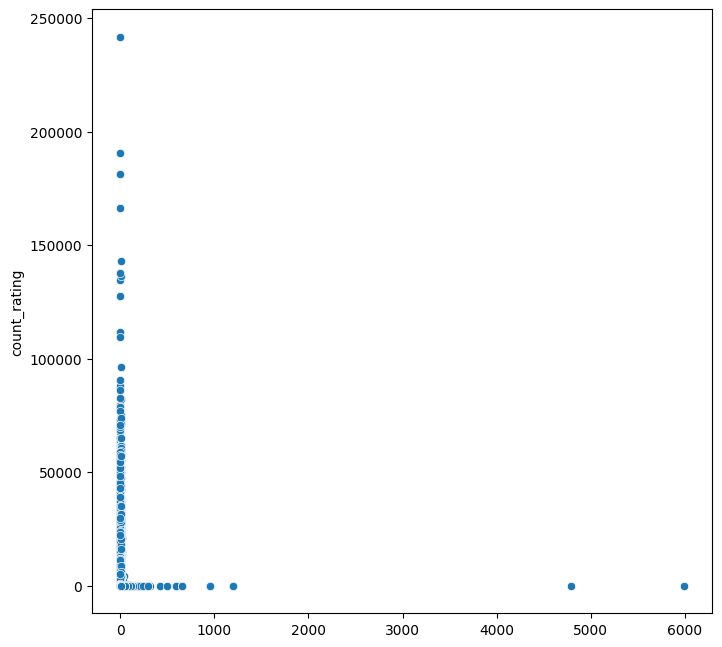

In [303]:
title2 = titles[(titles[['price','length']].notnull().all(1)) & (titles.length > 0) ]

price_per_hr = title2.price / (title2.length / 60)

plot = sns.scatterplot(x = price_per_hr,
                   y = title2.count_rating)

Text(0, 0.5, 'Price Per Hour Content')

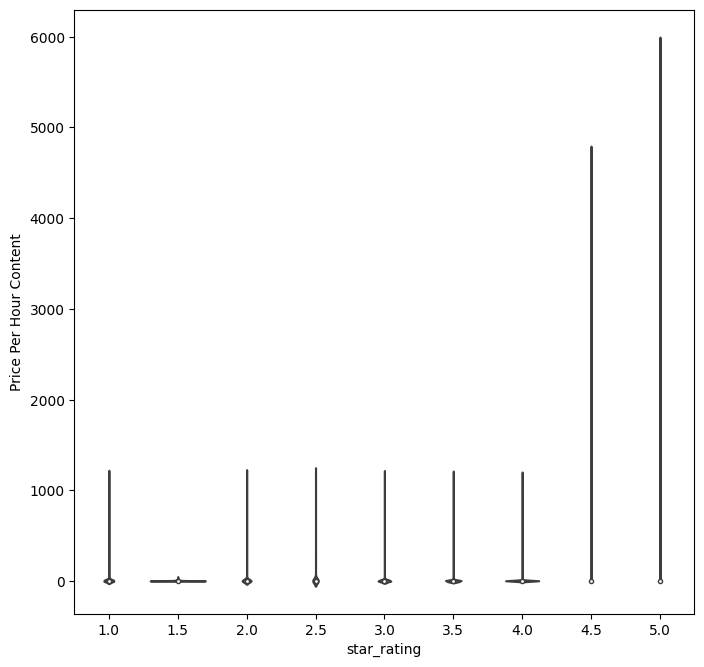

In [308]:
price_per_hr
plot = sns.violinplot(x= title2.star_rating,
                      y= price_per_hr)

plt.ylabel("Price Per Hour Content")

### Review Information EDA

There are 63664 audiobooks without a review


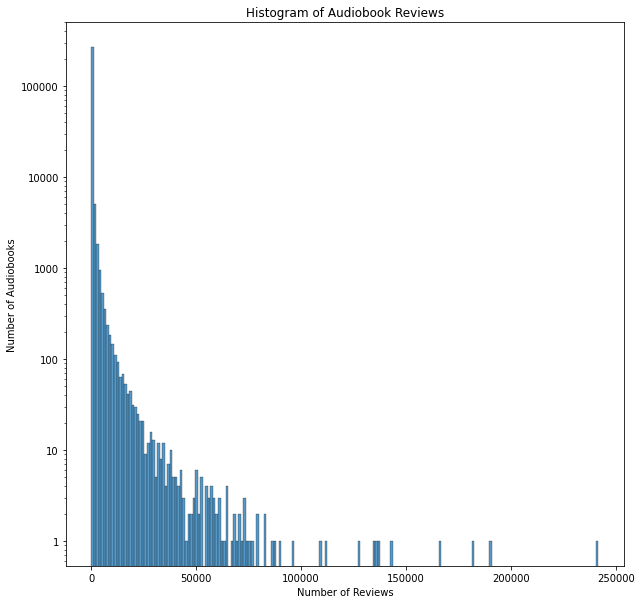

In [98]:
plot = sns.histplot(x = titles.count_rating, bins = 200)

plot.set_xlabel("Number of Reviews")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Reviews")
plot.set_yscale('log')

yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

print("There are {} audiobooks without a review".format(titles.loc[(titles.release_date <= '2021-05-10') & (titles.count_rating == 0)].shape[0]))
plt.savefig("./graphics/hist_reviews.png", bbox_inches = 'tight')

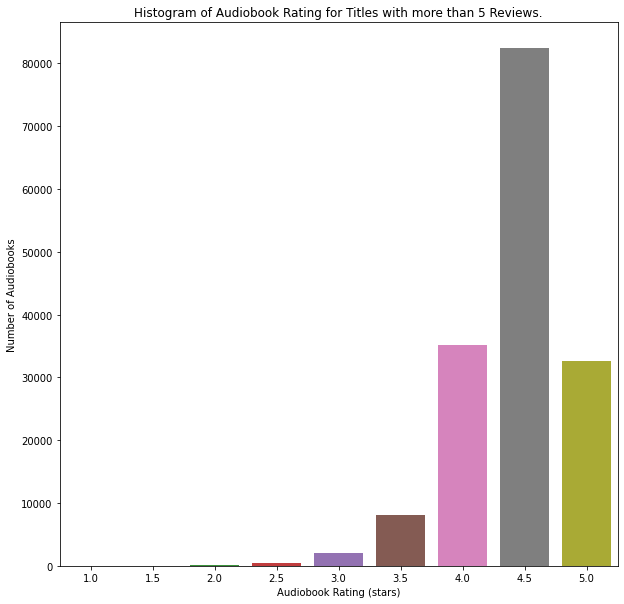

In [97]:
plot = sns.countplot(x = titles[titles.count_rating > 5]['star_rating'])

plot.set_xlabel("Audiobook Rating (stars)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Rating for Titles with more than 5 Reviews.")

plt.savefig("./graphics/hist_stars.png", bbox_inches = 'tight')

# Second order

<AxesSubplot:xlabel='category_number', ylabel='star_rating'>

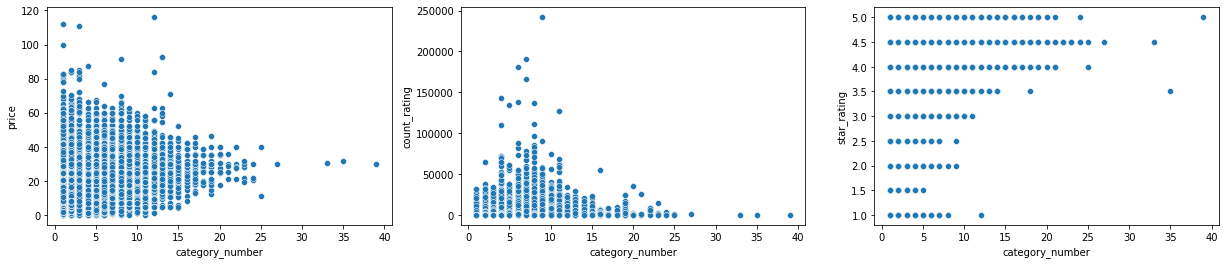

In [45]:
# price, reviews, rating by category number
#popular 

#sns.FacetGrid(titles, col = )


fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(21)
sns.scatterplot(x=titles.category_number,
                y=titles.price,
                ax= axs[0])
sns.scatterplot(x=titles.category_number,
                y=titles.count_rating,
                ax= axs[1])
sns.scatterplot(x=titles.category_number,
                y=titles.star_rating,
                ax= axs[2])


# use density plots

<AxesSubplot:xlabel='length', ylabel='count_rating'>

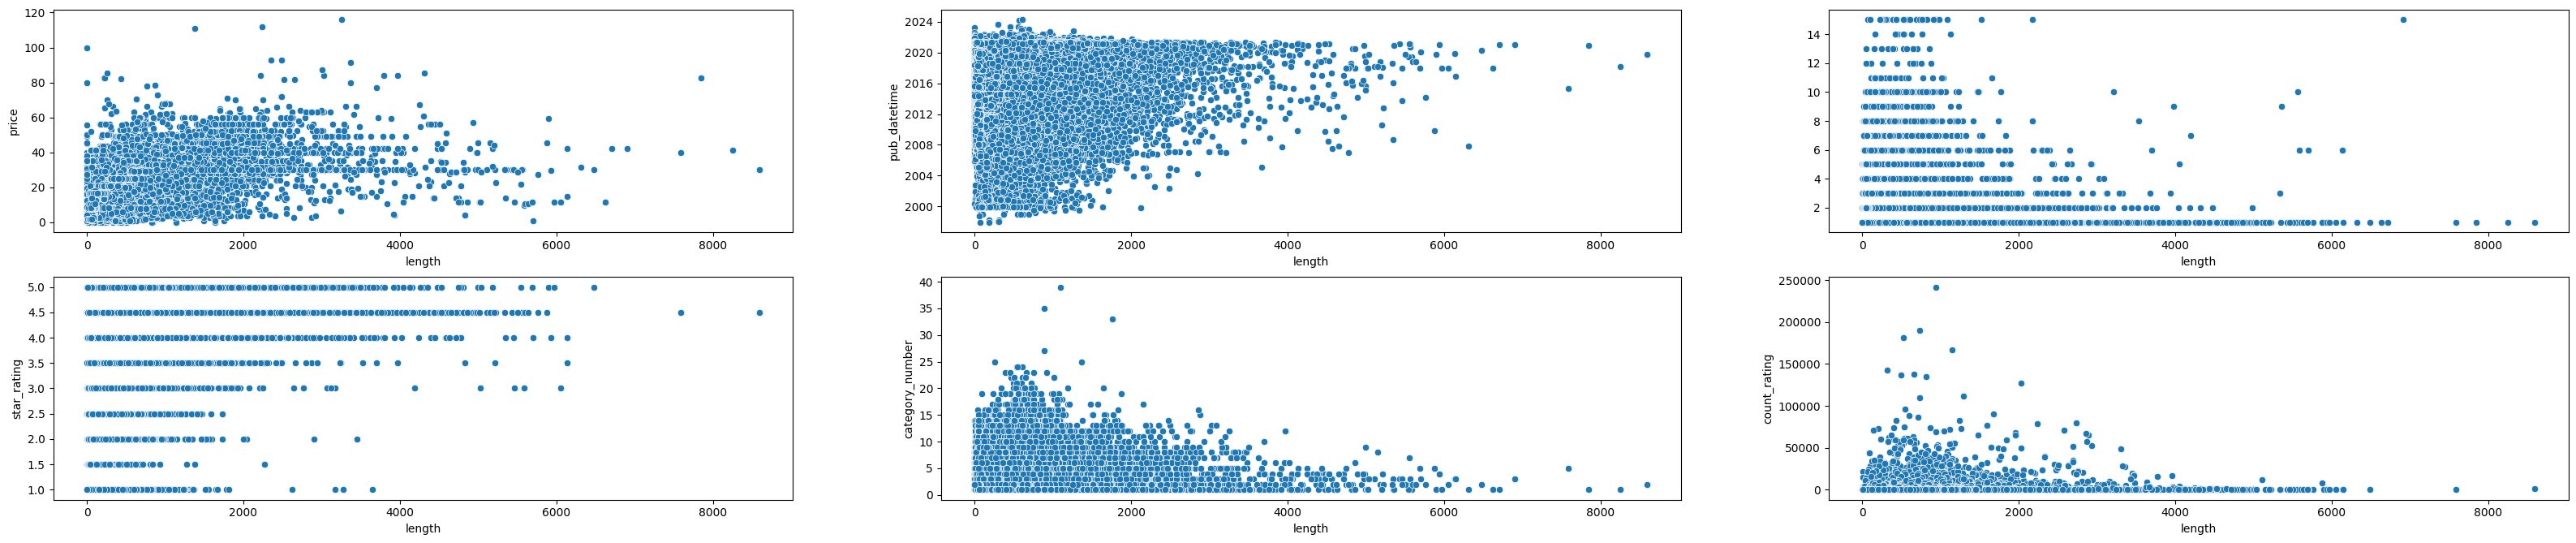

In [271]:
fig, axs = plt.subplots(nrows = 2, ncols=3)
fig.set_figwidth(40)

sns.scatterplot(x=titles.length,
                y=titles.price,
                ax= axs[0,0])
sns.scatterplot(x=titles.length,
                y=titles.pub_datetime,
                ax= axs[0,1])
sns.scatterplot(x=titles.length,
                y=[len(x) for x in titles.author],
                ax= axs[0,2])
sns.scatterplot(x=titles.length,
                y=titles.star_rating,
                ax= axs[1,0])
sns.scatterplot(x=titles.length,
                y=titles.category_number,
                ax= axs[1,1])
sns.scatterplot(x=titles.length,
                y=titles.count_rating,
                ax= axs[1,2])


# Axis Customization
#axs[].ylabel("")
#axs[].xlabel("An Author also Narrated")

AttributeError: 'numpy.ndarray' object has no attribute 'xlabel'

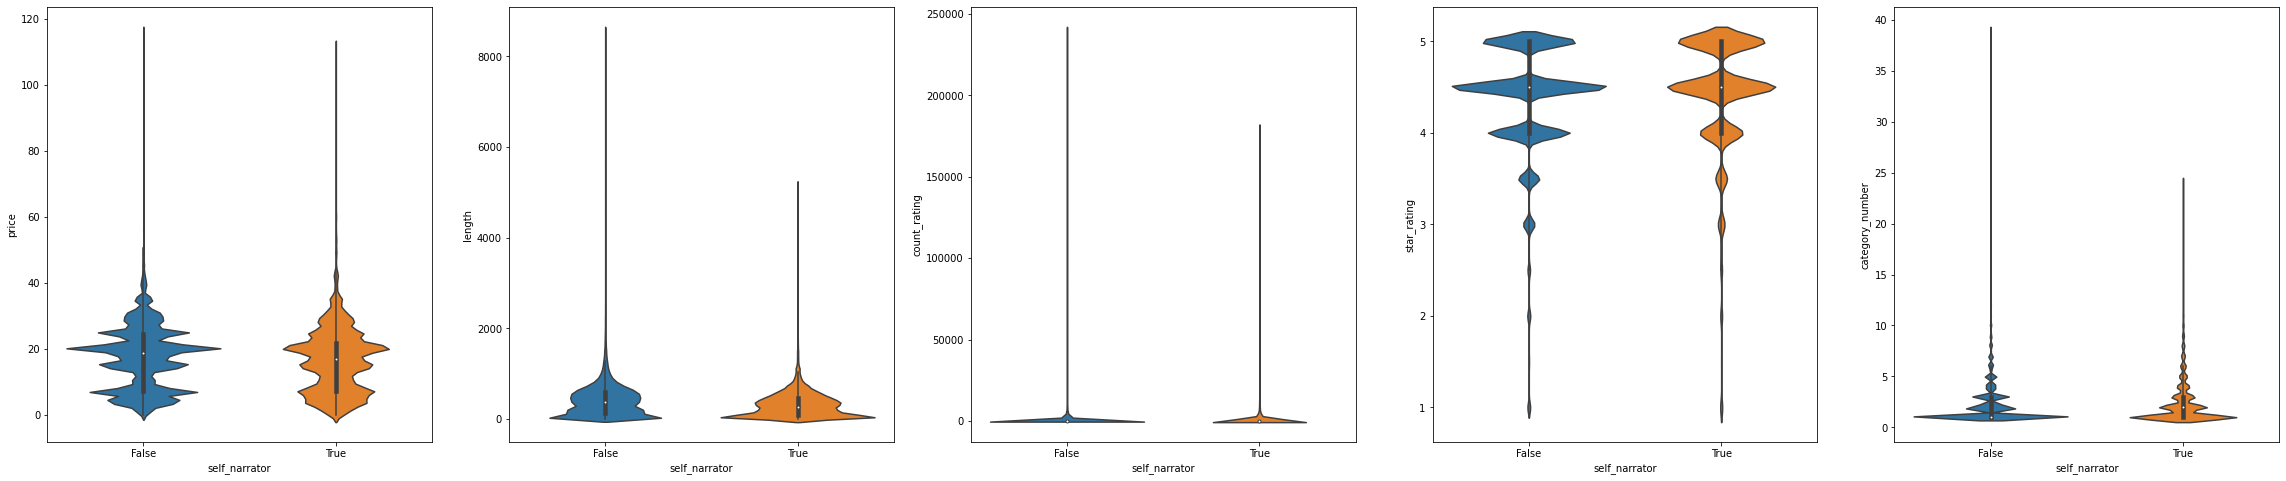

In [68]:
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.violinplot(x='self_narrator',
                y='price',
               data = titles,
                ax= axs[0])
sns.violinplot(x='self_narrator',
                y='length',
               data = titles,
                ax= axs[1])
sns.violinplot(x='self_narrator',
                y='count_rating',
               data = titles,
                ax= axs[2])
sns.violinplot(x='self_narrator',
                y='star_rating',
               data = titles,
                ax= axs[3])
sns.violinplot(x='self_narrator',
                y='category_number',
               data = titles,
                ax= axs[4])

# Axis Customization
axs[].ylabel("")
axs[].xlabel("An Author also Narrated")



#plt.savefig("./graphics/author_narr_comparisons.png", bbox_inches = 'tight')